# Step 1

**https://www.kaggle.com/datasets/ehallmar/daily-historical-stock-prices-1970-2018**

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv("historical_stock_prices.csv")
data = data[data['ticker'] == 'AAPL']  # Выборка Apple
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data = data['close'].resample('M').mean()  # Преобразуем данные в месячные значения

**Нормализация**

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

In [6]:
train_size = int(len(scaled_data) * 0.80)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

In [7]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [8]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

**LSTM**

In [13]:
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=30, batch_size=1, verbose=1)

Epoch 1/30
360/360 [==============================] - 2s 1ms/step - loss: 0.0012
Epoch 2/30
360/360 [==============================] - 0s 1ms/step - loss: 2.8034e-04
Epoch 3/30
360/360 [==============================] - 0s 1ms/step - loss: 2.6615e-05
Epoch 4/30
360/360 [==============================] - 0s 1ms/step - loss: 2.2648e-05
Epoch 5/30
360/360 [==============================] - 0s 1ms/step - loss: 2.5664e-05
Epoch 6/30
360/360 [==============================] - 0s 1ms/step - loss: 2.3918e-05
Epoch 7/30
360/360 [==============================] - 0s 1ms/step - loss: 2.4043e-05
Epoch 8/30
360/360 [==============================] - 0s 1ms/step - loss: 2.4501e-05
Epoch 9/30
360/360 [==============================] - 0s 969us/step - loss: 2.2549e-05
Epoch 10/30
360/360 [==============================] - 0s 1ms/step - loss: 2.3212e-05
Epoch 11/30
360/360 [==============================] - 0s 1ms/step - loss: 2.7469e-05
Epoch 12/30
360/360 [==============================] - 0s 971us/s

In [14]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

3/3 [==============================] - 0s 2ms/step


**Преобразование обратно в исходный масштаб**

In [15]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

**RMSE**

In [16]:
trainScore = mean_squared_error(trainY[0], trainPredict[:,0], squared=False)
testScore = mean_squared_error(testY[0], testPredict[:,0], squared=False)
print(f"Train Score: {trainScore:.2f} RMSE")
print(f"Test Score: {testScore:.2f} RMSE")

Train Score: 0.89 RMSE
Test Score: 7.26 RMSE


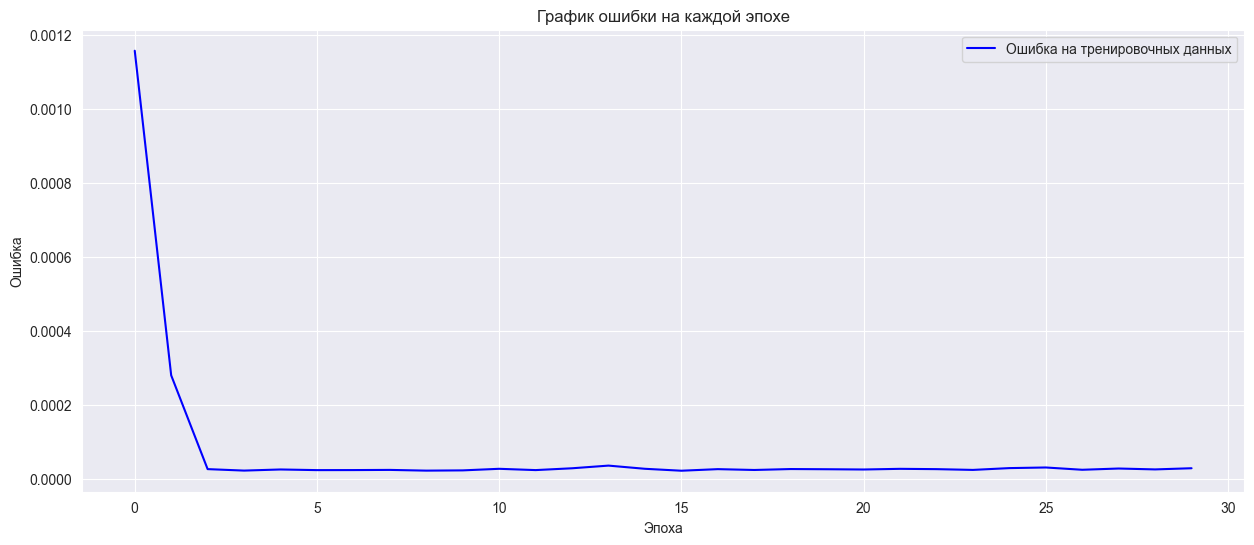

In [17]:
plt.figure(figsize=(15, 6))
plt.plot(history.history['loss'], color='blue', label='Ошибка на тренировочных данных')
plt.title('График ошибки на каждой эпохе')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

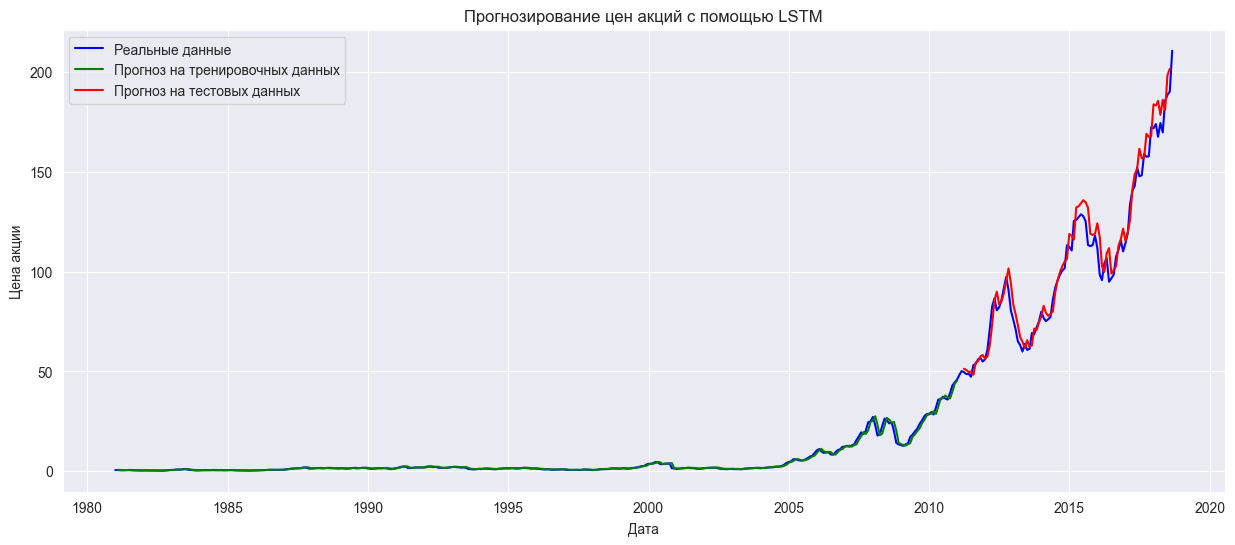

In [18]:
plt.figure(figsize=(15, 6))
plt.plot(data.index, data.values, color='blue', label='Реальные данные')
plt.plot(data.index[look_back:len(trainPredict)+look_back], trainPredict, color='green', label='Прогноз на тренировочных данных')
plt.plot(data.index[len(trainPredict)+(2*look_back)+1:len(data)-1], testPredict, color='red', label='Прогноз на тестовых данных')
plt.legend(loc='upper left')
plt.title('Прогнозирование цен акций с помощью LSTM')
plt.xlabel('Дата')
plt.ylabel('Цена акции')
plt.show()

# Step 2

In [19]:
# Обрезаю датасет, так как на полный не хватает мощности ноутбука
import pandas as pd


df = pd.read_csv("IMDB Movie Reviews.csv")
df = df.head(1000)
df.to_csv("IMDB Dataset short.csv", index=False)

In [20]:
import numpy as np
import pandas as pd
import torch
import time
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset


df = pd.read_csv("IMDB Dataset short.csv")
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'pos' else 0)
df['text'] = df['text'].str.replace('<br />', ' ')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 256

encodings = tokenizer.batch_encode_plus(df['text'].tolist(), truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
input_ids = encodings['input_ids']
attention_masks = encodings['attention_mask']
labels = torch.tensor(df['sentiment'].tolist())

train_inputs, val_inputs, train_labels, val_labels, train_masks, val_masks = train_test_split(input_ids, labels, attention_masks, test_size=0.2)

**настройка модели BERT**

In [21]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2, output_attentions=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 3
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_inputs) * epochs)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\data\innopolis\innopolis_labs_part2\point2\venv\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


**Обучение**

In [23]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=16)

def print_progress(epoch, loss):
    print(f'Эпоха: {epoch + 1}, Текущий loss: {loss.item()}')

train_losses = []
start_time = time.time()

for epoch in range(epochs):
    epoch_loss = 0
    for batch in train_dataloader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()

        if time.time() - start_time > 30:
            print_progress(epoch, loss)
            start_time = time.time()

    train_losses.append(epoch_loss / len(train_dataloader))

Эпоха: 1, Текущий loss: 0.6475316882133484
Эпоха: 1, Текущий loss: 0.7453327775001526
Эпоха: 1, Текущий loss: 0.6376497745513916
Эпоха: 1, Текущий loss: 0.6706981658935547
Эпоха: 1, Текущий loss: 0.6396239995956421
Эпоха: 1, Текущий loss: 0.5438281893730164
Эпоха: 1, Текущий loss: 0.49317508935928345
Эпоха: 1, Текущий loss: 0.6516278386116028
Эпоха: 1, Текущий loss: 0.4780460596084595
Эпоха: 1, Текущий loss: 0.2857736051082611
Эпоха: 1, Текущий loss: 0.28984254598617554
Эпоха: 1, Текущий loss: 0.201421320438385
Эпоха: 1, Текущий loss: 0.3755894601345062
Эпоха: 2, Текущий loss: 0.13340629637241364
Эпоха: 2, Текущий loss: 0.38506385684013367
Эпоха: 2, Текущий loss: 0.16466884315013885
Эпоха: 2, Текущий loss: 0.1436460018157959
Эпоха: 2, Текущий loss: 0.24204665422439575
Эпоха: 2, Текущий loss: 0.21689774096012115
Эпоха: 2, Текущий loss: 0.21731139719486237
Эпоха: 2, Текущий loss: 0.16576488316059113
Эпоха: 2, Текущий loss: 0.10295241326093674
Эпоха: 2, Текущий loss: 0.1575525552034378
Эп

**Оценка**

In [25]:
model.eval()
predictions, true_labels = [], []

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, batch_size=16)

for batch in val_dataloader:
    with torch.no_grad():
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    predictions.extend(np.argmax(logits, axis=1))
    true_labels.extend(label_ids)

precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')
print(f"Точность: {precision:.4f}, Полнота: {recall:.4f}, F1-мера: {f1:.4f}")

Точность: 0.7944, Полнота: 0.9341, F1-мера: 0.8586


**Визуализация**

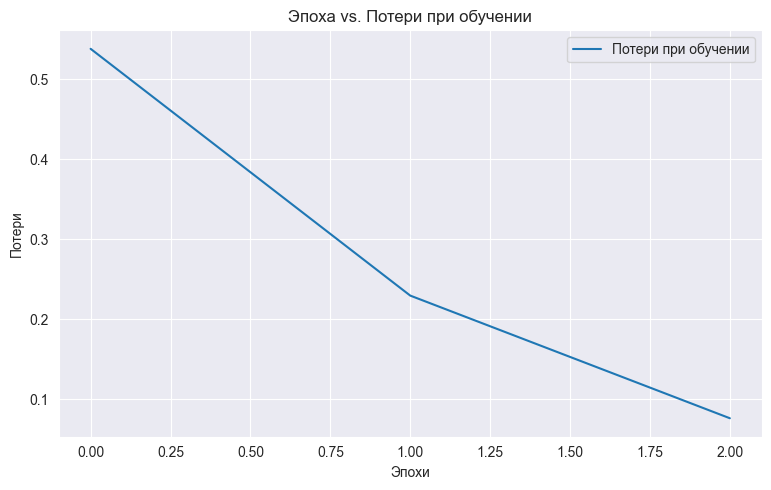

              precision    recall  f1-score   support

    negative       0.94      0.80      0.86       109
    positive       0.79      0.93      0.86        91

    accuracy                           0.86       200
   macro avg       0.86      0.87      0.86       200
weighted avg       0.87      0.86      0.86       200



In [26]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Потери при обучении")
plt.title("Эпоха vs. Потери при обучении")
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.legend()

plt.tight_layout()
plt.show()

print(classification_report(true_labels, predictions, target_names=["negative", "positive"]))

**Визуализация внимания**

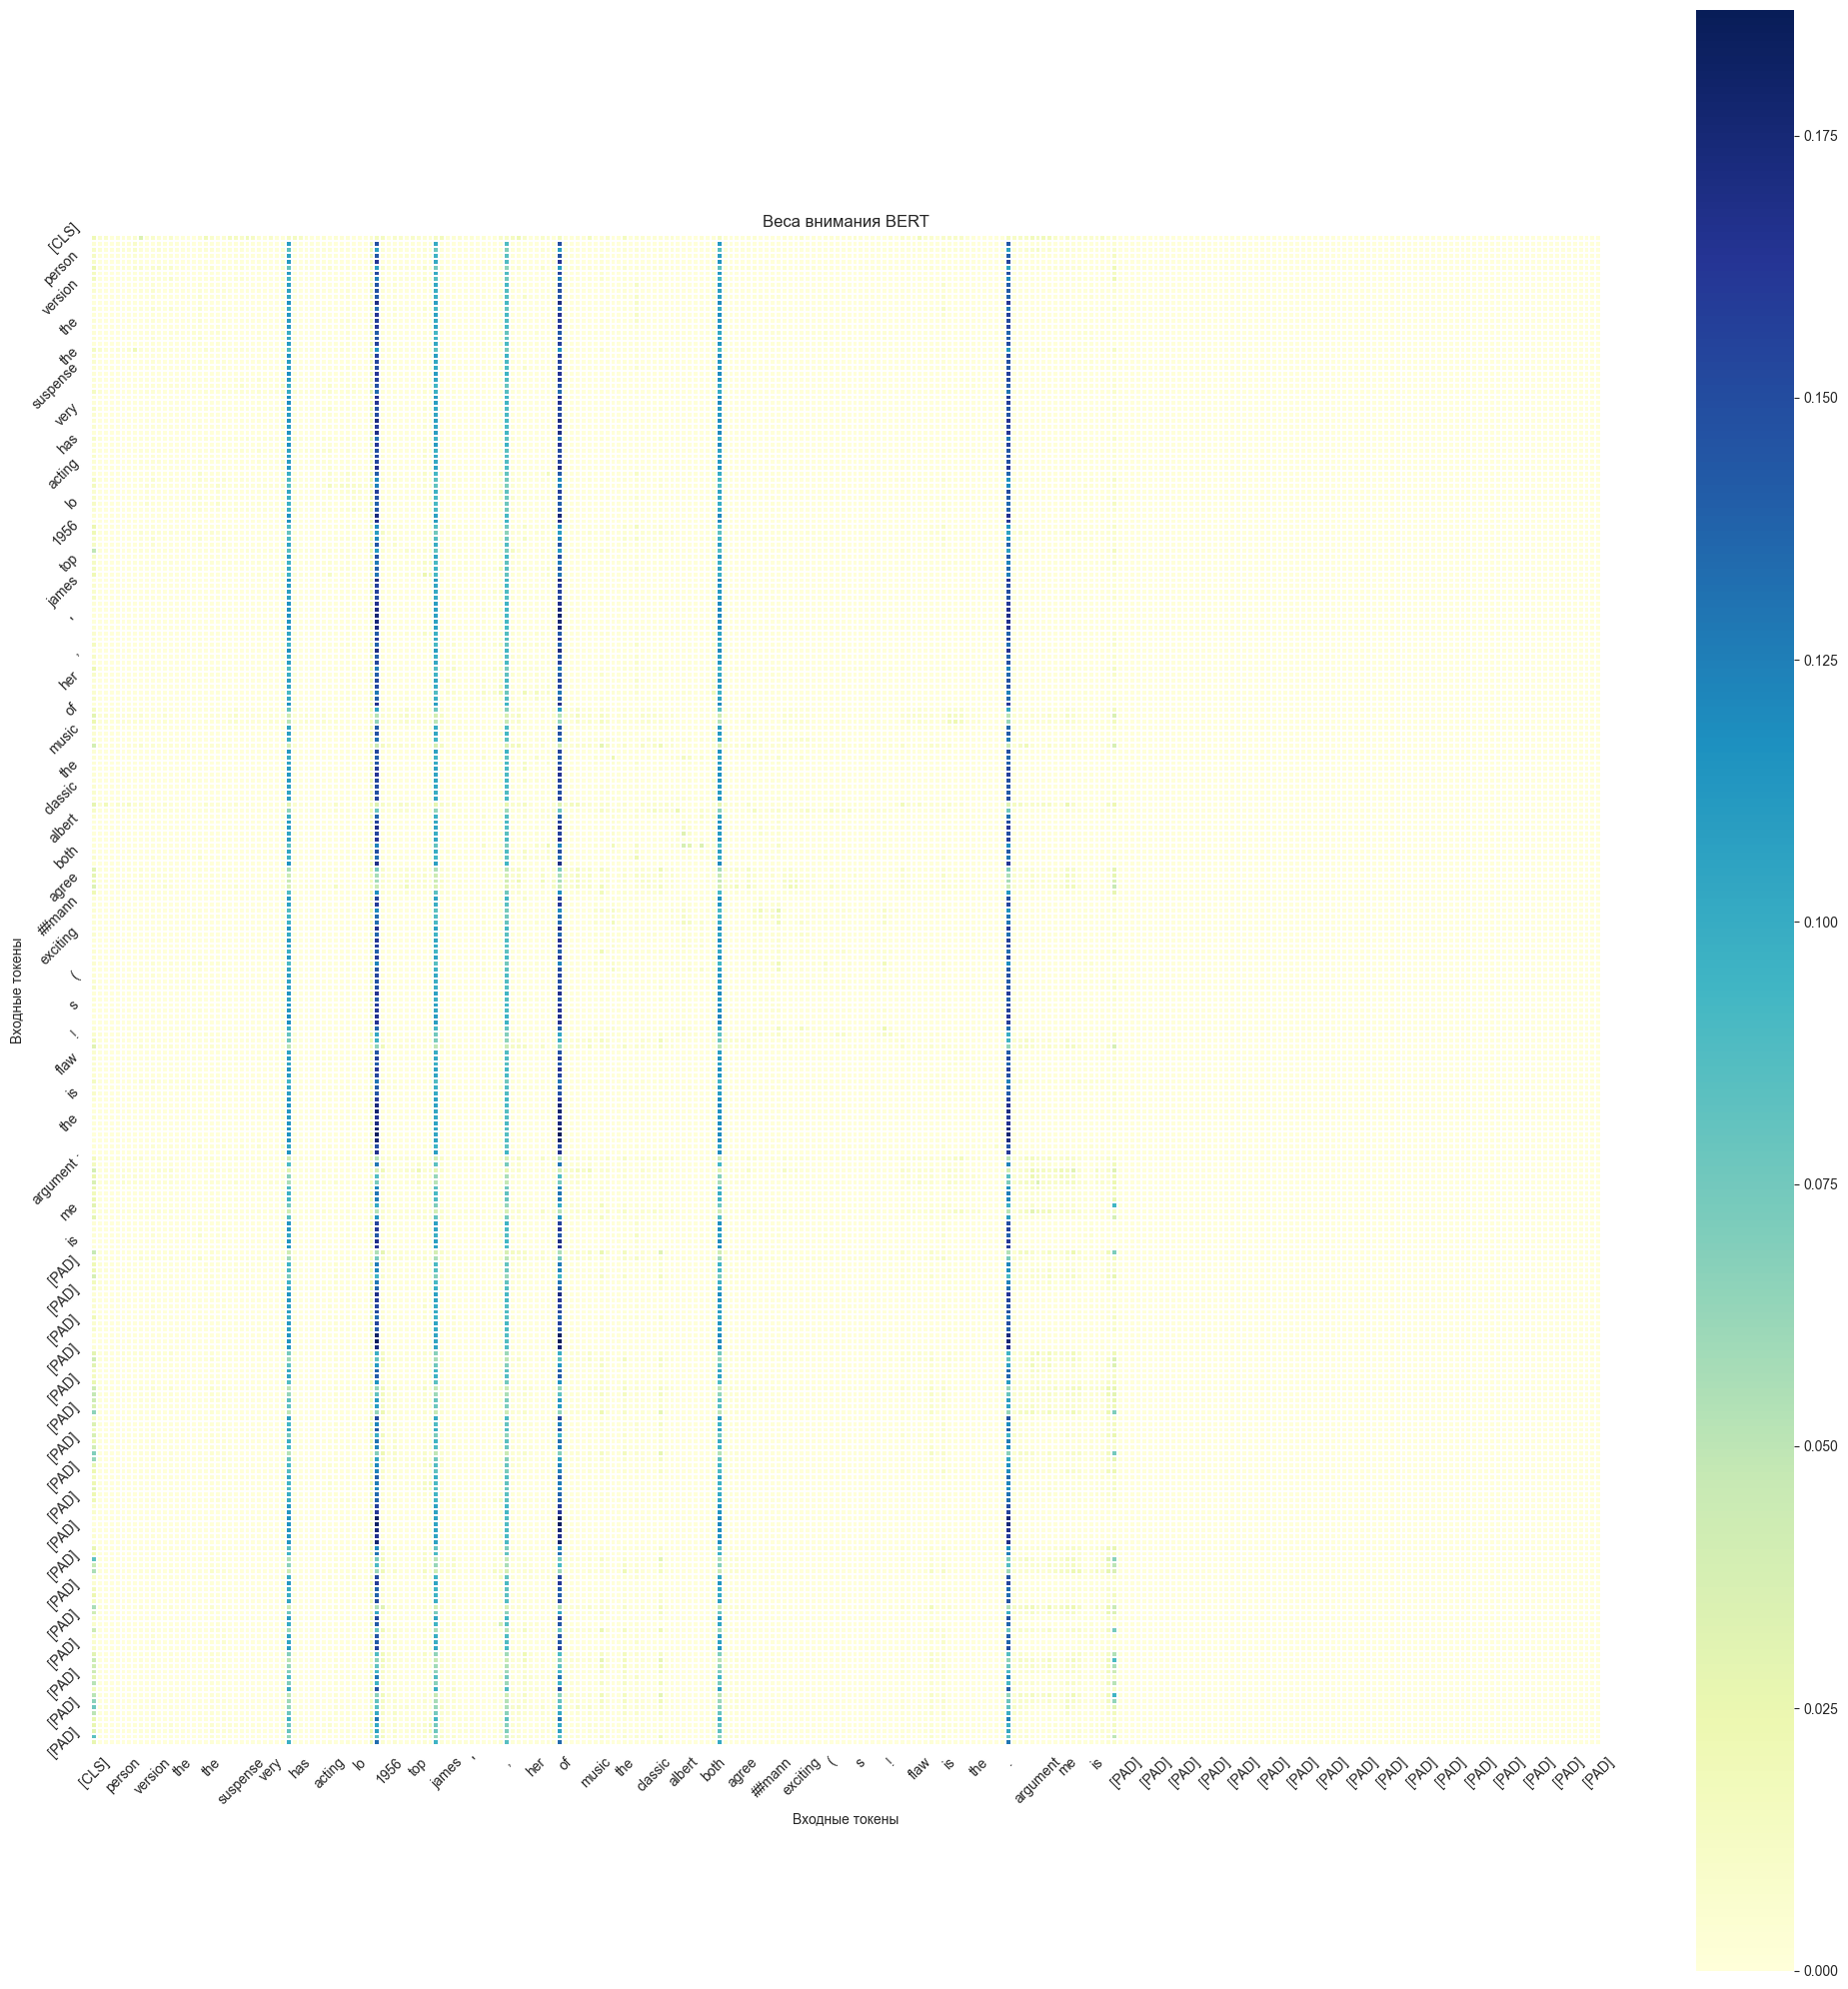

In [29]:
def plot_attention(attention, sentence, interval=5):
    fig, ax = plt.subplots(figsize=(20, 20))
    attention = attention[:len(sentence), :len(sentence)]
    sns.heatmap(attention, xticklabels=sentence, yticklabels=sentence, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)

    # Устанавливаю интервалы между метками и уменьшаю размер шрифта для оси X
    ax.set_xticks(ax.get_xticks()[::interval])
    ax.set_xticklabels(sentence[::interval], rotation=45, fontsize=10)

    # Устанавливаю интервалы между метками и уменьшаю размер шрифта для оси Y
    ax.set_yticks(ax.get_yticks()[::interval])
    ax.set_yticklabels(sentence[::interval], rotation=45, fontsize=10)

    plt.xlabel('Входные токены')
    plt.ylabel('Входные токены')
    plt.title('Веса внимания BERT')
    plt.tight_layout()
    plt.show()

# with torch.no_grad():
#     outputs = model(inputs.to(device), attention_mask=masks.to(device))
#     attentions = outputs.attentions

for batch in val_dataloader:
    input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
    break  #

with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    attentions = outputs.attentions

# attention = attentions[-1][0][0].cpu().numpy()
# sentence = tokenizer.convert_ids_to_tokens(inputs[0])
# plot_attention(attention, sentence)

attention = attentions[-1][0][0].cpu().numpy()
sentence = tokenizer.convert_ids_to_tokens(input_ids[0])
plot_attention(attention, sentence)

# Step3

In [24]:
# pip uninstall tensorflow-intel
# https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1
# pip install tensorflow-hub

In [30]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

%matplotlib inline

path = 'img.jpg'
image_np = cv2.imread(path)

# BGR в RGB
image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

# Изображение в тензор
input_tensor = tf.image.convert_image_dtype(image_np, dtype=tf.uint8)
input_tensor = input_tensor[tf.newaxis, ...]

**RetinaNET из TF Hub**

In [31]:
detector = hub.load("https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1")

In [32]:
detector_output = detector(input_tensor)

# Порог для фильтрации детекций
threshold = 0.3

**Детекции на изображении**

In [33]:
for i in range(int(detector_output["num_detections"])):
    score = detector_output["detection_scores"][0][i].numpy()
    if score > threshold:
        box = detector_output["detection_boxes"][0][i].numpy()
        y1, x1, y2, x2 = (box * [image_np.shape[0], image_np.shape[1], image_np.shape[0], image_np.shape[1]]).astype(int)
        cv2.rectangle(image_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = f"Class: {detector_output['detection_classes'][0][i].numpy()}, Score: {score:.2f}"
        cv2.putText(image_np, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

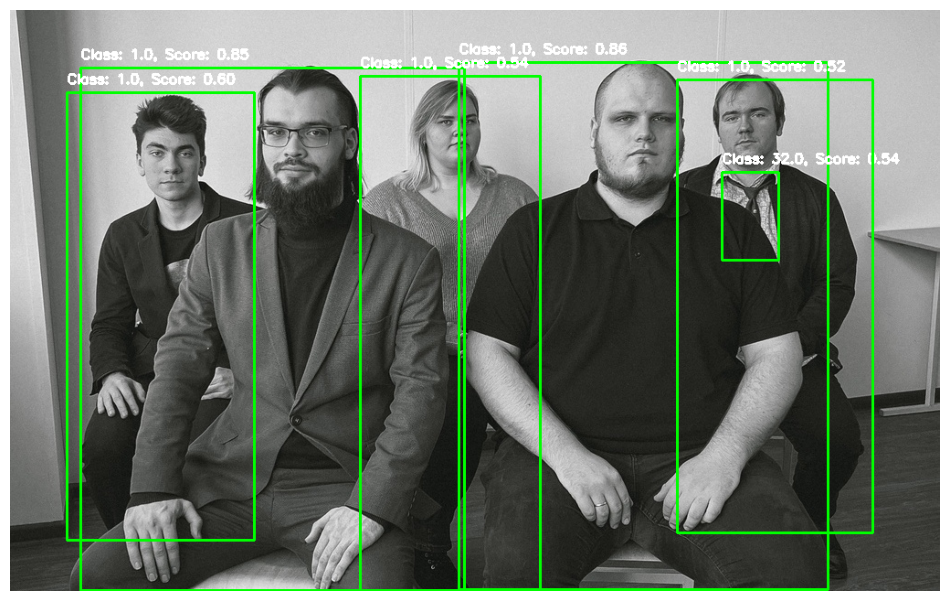

In [34]:
plt.figure(figsize=(12, 8))
plt.imshow(image_np)
plt.axis('off')
plt.show()